In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import torch
import gc
import os
import sys
%matplotlib notebook
import matplotlib.pyplot as plt

# def printmem():
#     allocated = torch.cuda.memory_allocated()
#     cached = torch.cuda.memory_cached()
#     print('Allocated:', str(allocated), '['+str(round(allocated/1000000000,3))+' GB]')
#     print('   Cached:', str(cached), '['+str(round(cached/1000000000,3))+' GB]')

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
# printmem()



In [2]:
from criteria import KIDMindLoss
from helpers import Trainer
from helpers import Logger
from helpers import Trial
from mibi_dataloader import KID_Data
from modules import Mind_of_KID
import utils

# printmem()

In [3]:
# Load the data
main_dir = '/home/hazmat/Documents/projectKID/'
train_dir = main_dir + 'KID_memory/'
# test_dir = main_dir + 'low_AD/'
modl_dir = main_dir + 'models/'
rslt_dir = main_dir + 'results/'

train_ds = KID_Data(folder=train_dir, crop=55, scale=1, stride=1)
# test_ds = MIBIData(folder=test_dir, crop=32, scale=10, stride=16)

finished loading
There are  10000 samples


In [598]:
laddernet_args = dict()

# laddernet_args['batchnorm'] = False

# kidmind = Mind_of_KID()
kidmind = Mind_of_KID.load_model('/home/hazmat/Documents/projectKID/models/2019Aug23_19-19-53/', 'model_2999')
kidmind.cuda()
pass

# laddernet.cuda()
# print(owlnet)

In [599]:
kidmind_logger = Logger(['loss'])

In [600]:
kidmind_trainer = Trainer()

In [601]:
# LadderNet training parameters
kidmind_train_args = dict()
kidmind_train_args['lr'] = 0.001
kidmind_train_args['batch_size'] = 1000
kidmind_train_args['epochs'] = 1000
kidmind_train_args['report'] = 5
kidmind_train_args['crop'] = 55
kidmind_train_args['clip'] = None
kidmind_train_args['decay'] = 0
kidmind_train_args['restart'] = -1
kidmind_train_args['epoch_frac'] = 1
# laddernet_train_args['decay'] = 1e-5

# LadderNet loss parameters
kidmind_loss_args = {
    'alpha': 1, # sensory loss
    'beta': 1, # inverse loss
    'gamma': 1, # forward loss
    'delta': 1 # perceptual loss
}

train_ds.set_crop(kidmind_train_args['crop'])

In [602]:
# kidmind_train_args['continue'] = False
# kidmind.set_noise_level(0)
# kidmind_criterion = KIDMindLoss(**kidmind_loss_args)
# kidmind_trainer.train(kidmind, train_ds, kidmind_criterion, kidmind_logger, '/home/hazmat/Documents/projectKID/models/', **kidmind_train_args)

tensor([[ 0.6057,  0.0378, -0.5185,  0.1384,  0.6315,  0.2429, -0.7348,  0.6950,
          0.9055]], device='cuda:0', grad_fn=<TanhBackward>)


/home/hazmat/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


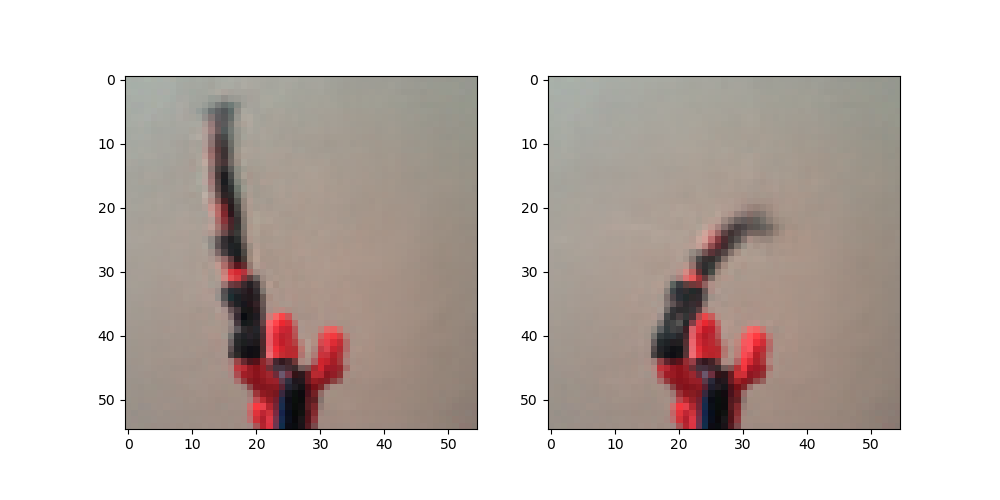

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [603]:
import numpy as np
import time
kidmind.set_noise_level(0)
kidmind.eval()

idx1 = 20
idx2 = 48

batch1 = train_ds.get_samples([idx1])
batch2 = train_ds.get_samples([idx2])

batch1 = kidmind.forward(**batch1)
batch2 = kidmind.forward(**batch2)

img1 = batch1['~s_i'][0,:,:,:].transpose(0,1).transpose(1,2).detach()
img2 = batch2['~s_i'][0,:,:,:].transpose(0,1).transpose(1,2).detach()

p = batch2['p_i']
print(p)

fig = plt.figure(figsize=[10,5])
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

ax1.imshow(img1.cpu())
ax2.imshow(img2.cpu())

In [585]:
def run_kid_run(start_state, action_sequence, model):
    action_sequence = clip_actions(action_sequence)
    p_states = list()
    r_states = list()
    s_states = list()
    p_states.append(start_state['p_i'])
    r_states.append(start_state['r_i'])
    s_states.append(start_state['s_i'])
    
    for i in range(len(action_sequence)):
        p_next = kidmind.forward_kinematics_model.forward(p_states[i], action_sequence[i])
        r_next = kidmind.perceptual_model.decode(p_next)
        s_next = kidmind.sensory_model.decode(r_next)
        p_states.append(p_next)
        r_states.append(r_next)
        s_states.append(s_next)
    
    return s_states, r_states, p_states

def calc_loss(target_state, state_sequence, action_sequence):
    mse = torch.nn.MSELoss()
    target_loss = 0
    control_loss = 0
    for i in range(len(action_sequence)):
        control_loss = control_loss + mse(torch.zeros(1,3,device='cuda'), action_sequence[i])
        # target_loss = target_loss + mse(target_state, state_sequence[-1])
    loss = target_loss + 0.1*control_loss/len(action_sequence) + 10*mse(target_state, state_sequence[-1])
    return loss

def clip_actions(actions):
    clip_val = 1
    for i in range(len(actions)):
        action = actions[i]
        r = torch.norm(action).detach()
        if r > clip_val:
            action = action / r * clip_val
            actions[i] = action
    return actions

def gen_actions(**kwargs):
    if 'N' in kwargs:
        N = kwargs['N']
        actions = list()
        for i in range(N):
            action = torch.randn(1, 3, requires_grad=True, device='cuda')
            actions.append(action)
    elif 'actions' in kwargs:
        parent = kwargs['actions']
        actions = list()
        noise_lvl = kwargs['noise_lvl']
        for i in range(len(actions)):
            action = parent[i] + torch.randn(1, 3, requires_grad=True, device='cuda') * noise_lvl
            action = torch.tensor(action)
            actions.append(action)
    return actions

def calc_fitness(population, start_state, target_state, model):
    fitness = np.zeros(len(population))
    for i in range(len(population)):
        action_sequence = population[i]
        s_states, r_states, p_states = run_kid_run(start_state, action_sequence, model)
        state_sequence = r_states
        fitness[i] = calc_loss(target_state['r_i'], state_sequence, action_sequence)
    return fitness

def seed_population(**kwargs):
    N = kwargs['N']
    pop_size = kwargs['pop_size']
    population = list()
    for i in range(pop_size):
        population.append(gen_actions(N=N))
    return population

def optimize_seq(actions, start, target, model, steps, learning_rate):
#     for i in range(len(actions)):
#         actions[i] = torch.tensor(actions[i])
    optimizer = torch.optim.Adam(actions, lr=learning_rate)
    for i in range(steps):
        optimizer.zero_grad()
        model.zero_grad()
        s_states, r_states, p_states = run_kid_run(start, actions, model)
        loss = calc_loss(target['r_i'], r_states, actions)
        loss.backward(retain_graph=True)
        optimizer.step()
        print(index, loss, end='\r')
#     for i in range(len(actions)):
#         actions[i] = torch.tensor(actions[i])
    return actions

def optimize_pop(population, start, target, model, steps, learning_rate):
    for i in range(len(population)):
        population[i] = optimize_seq(population[i], start, target, model, steps, learning_rate)
    return population

In [604]:
start_batch = train_ds.get_samples([idx1])
target_batch = train_ds.get_samples([idx2])

start = kidmind.forward(**start_batch)
target = kidmind.forward(**target_batch)

In [586]:
population = seed_population(N=5, pop_size=1)

In [524]:
pre_fitness = calc_fitness(population, start, target, kidmind)
population = optimize_pop(population, start, target, kidmind, 100, 1)
fitness = calc_fitness(population, start, target, kidmind)

/home/hazmat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/home/hazmat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [525]:
for i in range(len(fitness)):
    print(pre_fitness[i], fitness[i])

0.030729690566658974 0.030729690566658974


In [ ]:
# Generate a population of action sequences
# Optimize each action sequence
# Order the action sequences

In [474]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [605]:
# kidmind = Mind_of_KID.load_model('/home/hazmat/Documents/projectKID/models/2019Aug23_19-19-53/', 'model_2999')
# kidmind.cuda()
actions = gen_actions(N=5)
print(actions)
actions = optimize_seq(actions, start, target, kidmind, 100, 1)

[tensor([[-0.0157,  0.2815, -2.2831]], device='cuda:0', requires_grad=True), tensor([[-0.6816, -1.5303,  0.3346]], device='cuda:0', requires_grad=True), tensor([[ 0.4175,  1.8723, -0.0825]], device='cuda:0', requires_grad=True), tensor([[ 1.0077, -1.0291, -1.2656]], device='cuda:0', requires_grad=True), tensor([[ 1.6240, -0.6804, -0.1458]], device='cuda:0', requires_grad=True)]


In [558]:
s_states = list()
r_states = list()
p_states = list()

In [596]:
optimizer = torch.optim.Adam(actions, lr=0.1)
loss = 1
index = 0
while index < 100:
#     if np.mod(index, 100) == 0:
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = 0.1
    index += 1
    optimizer.zero_grad()
    # model.zero_grad()
    # for i in range(len(actions)):
        # actions[i] = actions[i] + torch.randn_like(actions[i])*0.0001
    s_states, r_states, p_states = run_kid_run(start, actions, kidmind)
    loss = calc_loss(target['r_i'], r_states, actions)
    loss.backward(retain_graph=True)
    optimizer.step()
    print(index, loss, end='\r')
# print(loss)
# print(actions[0])

In [467]:
# print(target['r_i'])
# print(r_states[-1])
# print(r_states[-2])
for i in range(len(actions)):
    print(actions[i])

tensor([[-0.7284,  0.3202,  0.6057]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[-0.0039,  0.0019,  0.0064]], device='cuda:0', requires_grad=True)
tensor([[-0.5417, -0.8345,  0.1006]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[0.1624, 0.9630, 0.2149]], device='cuda:0', grad_fn=<MulBackward0>)
tensor([[0.4961, 0.4405, 0.7482]], device='cuda:0', grad_fn=<MulBackward0>)


/home/hazmat/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


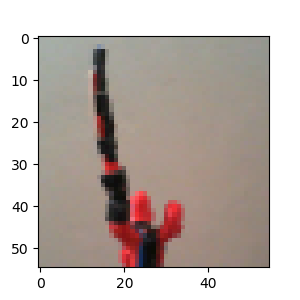

<IPython.core.display.Javascript object>


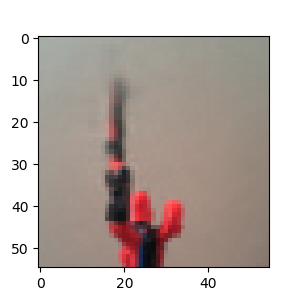

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


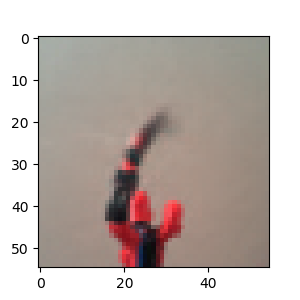

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


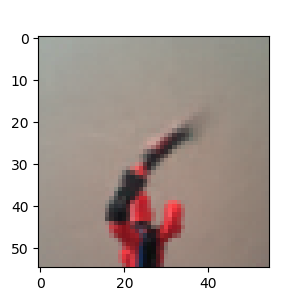

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


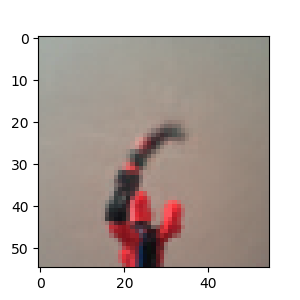

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


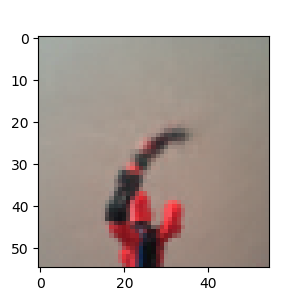

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [578]:
# actions[0] = torch.tensor([[1,-1,0]]).cuda().float()
# actions[1] = torch.tensor([[1,-1,0]]).cuda().float()
s_states, r_states, p_states = run_kid_run(start, actions, kidmind)
for i in range(len(s_states)):
    fig = plt.figure(figsize=[3,3])
    plt.imshow(s_states[i][0,:,:,:].transpose(0,1).transpose(1,2).detach().cpu())

In [460]:
# from mpl_toolkits.mplot3d import Axes3D

# import matplotlib.pyplot as plt
# import numpy as np

# fig = plt.figure(figsize=[10,10])
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.scatter(x[:,0], x[:,1], x[:,2], '.')

In [461]:
actions

[tensor([[-0.3143,  0.8304, -0.4601]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[-0.0545,  0.0273,  0.0887]], device='cuda:0', requires_grad=True),
 tensor([[ 0.2027, -0.8757, -0.4383]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[ 0.3810, -0.0902,  0.9202]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[-0.8542, -0.5175,  0.0500]], device='cuda:0', grad_fn=<MulBackward0>)]

In [462]:
print(p_states[0])
print(actions[0])
p_next = kidmind.forward_kinematics_model.forward(p_states[0], actions[0])
print('')
print(p_next)
print(p_states[1])
print('')
print(target['r_i'])
print(r_states[-1])

tensor([[ 0.0945, -0.8165,  0.5252,  0.3620,  0.6739, -0.7171, -0.6295,  0.6422,
          0.4967]], device='cuda:0', grad_fn=<TanhBackward>)
tensor([[-0.3143,  0.8304, -0.4601]], device='cuda:0', grad_fn=<MulBackward0>)

tensor([[ 0.2868, -0.5485,  0.7563,  0.0636,  0.6697, -0.4508, -0.6207,  0.6388,
          0.0936]], device='cuda:0', grad_fn=<TanhBackward>)
tensor([[ 0.2868, -0.5485,  0.7563,  0.0636,  0.6697, -0.4508, -0.6207,  0.6388,
          0.0936]], device='cuda:0', grad_fn=<TanhBackward>)

tensor([[ 0.6590,  0.6492, -0.6481]], device='cuda:0', grad_fn=<TanhBackward>)
tensor([[ 0.6368,  0.6436, -0.6468]], device='cuda:0', grad_fn=<AddmmBackward>)


In [ ]:
r_states[1]

In [374]:
p_states[2]

tensor([[ 0.1265, -0.6296,  0.3933, -0.0595,  0.7096, -0.5337, -0.6592,  0.6655,
          0.5603]], device='cuda:0', grad_fn=<TanhBackward>)

In [ ]:
print('start: ', p_states[0])
print('action:', actions[0])
p_next = kidmind.forward_kinematics_model.forward(p_states[0], actions[0])
print('')
print(p_next)
for i in range(len(p_states)):
    print(p_states[i])

In [ ]:
import numpy as np
batch = train_ds.get_samples(np.random.permutation(1000))
s_states = batch['s_i']
r_states, pre_r_states = kidmind.sensory_model.encode(s_states)

In [ ]:
data = pre_r_states[:,0].cpu().detach().numpy()
# print(data)
hist = np.histogram(data)

In [ ]:
torch.mean(r_states,0)

In [ ]:
torch.std(r_states,0)

In [ ]:
torch.sqrt(kidmind.sensory_model.bn8.running_var)

In [ ]:
fig = plt.figure()
plt.hist(data, bins=1000)
print(torch.std(torch.tensor(data)))